In [80]:
import numpy as np
from matplotlib import pyplot as plt
import scipy

from typing import Union

In [2]:
def generate_gaussian_distribution(
        num_points, mean, std, range_min, range_max
):
    grid = np.linspace(range_min, range_max, num_points)
    pdf_values = 1/(std * np.sqrt(2 * np.pi)) * np.exp(
        -1/2 * np.power((grid - mean)/std, 2))
    pdf_values /= pdf_values.sum()
    return grid, pdf_values

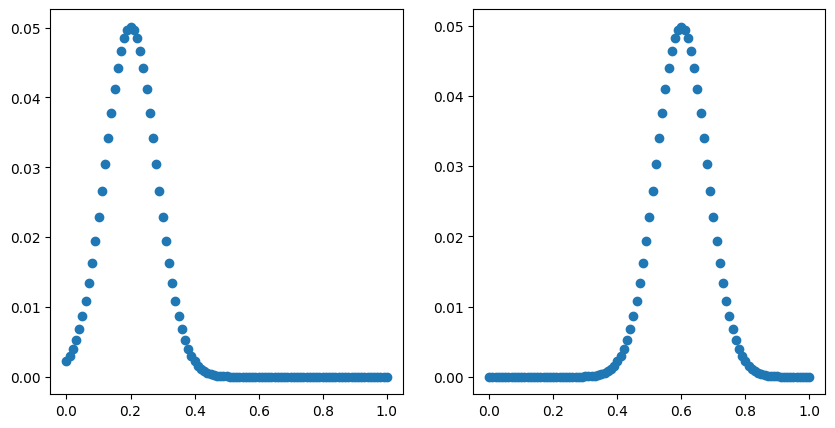

In [9]:
n = 100 + 1   # Number of points
std = 0.08
range_min = 0
range_max = 1

grid1, pdf1 = generate_gaussian_distribution(n, 0.2, std, range_min, range_max)
grid2, pdf2 = generate_gaussian_distribution(n, 0.6, std, range_min, range_max)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].scatter(grid1, pdf1)
axs[1].scatter(grid2, pdf2)
# fig.show()

# The Back-and-Forth Algorithm

Let our $\Omega \subset \R^d$ be a convex and compact region. Consider a cost function of a form
$$ c(x, y) = h(y-x) $$
where function $h : \R^d \to \R$ is strictly convex and even function.

The optimal transport problem is being stated in it's dual form:
$$ C(\mu, \nu) = \sup_{\varphi : \Omega \to \R} \int_{\Omega} \varphi(y) \nu(y) dy + \int_{\Omega} (\varphi)^{c} (x) \mu(x) dx $$
for two measures $\mu$ and $\nu$ and continuous functions $\varphi: \Omega \to \R$.

The operation $(\cdot)^{c}$ is called __c-transform__ and is being defined as:
$$ \varphi^{c}(x) = \inf_{y \in \Omega} \left\{ c(x,y) - \varphi(y) \right\} $$

Also we define two functionals $J: \mathcal{H} \to \R$ and $I: \mathcal{H} \to \R$
$$ J(\varphi) = \int_{\Omega} \varphi d \nu + \int_{\Omega} \varphi^{c} d \mu $$
$$ I(\psi) = \int_{\Omega} \psi^{c} d \nu + \int_{\Omega} \psi d \mu $$

And our operating Hilbert space will be
$$ \dot{H}^1 = \left\{ \varphi : \Omega \to \R : \int_{\Omega} \varphi dx = 0 \text{ and } \nabla \varphi \in L^2 (\Omega) \right\} $$

We get the following update scheme
$$
\begin{align}
\varphi_{n+1/2} &= \varphi_{n} + \sigma \nabla_{\dot{H}^1} J(\varphi_{n}) \\
\psi_{n+1/2}    &= (\varphi_{n+1/2})^{c} \\
\psi_{n+1}    &= \psi_{n} + \sigma \nabla_{\dot{H}^1} I(\psi_{n}) \\
\varphi_{n+1}   &= (\psi_{n+1})^{c}
\end{align}
$$

where the functionals $J(\varphi_n)$ and $I(\psi_n)$ are defined as:
$$ J(\varphi) = \int_{\Omega} \varphi d \nu + \int_{\Omega} (\varphi)^{c} d \mu $$
$$ I(\psi) = \int_{\Omega} (\psi)^{c} d \nu + \int_{\Omega} \psi d \mu $$
over the space of continuous functions $\varphi : \Omega \to \R$ and $\psi : \Omega \to \R$.

How do we compute $\nabla_{\dot{H}^1} J(\varphi_n)$ or $\nabla_{\dot{H}^1} I(\psi_n)$?

By Lemma 3, we get that if $\varphi$ is c-concave, the first variation of $J$ can be expressed as
$$ \delta J_{\varphi} = \nu - T_{\varphi \#} \mu $$
and if $\psi$ is c-concave, the first variation of $I$ can be expressed as
$$ \delta I_{\psi} = \mu - T_{\psi \#} \nu $$

**some math .....**

At the end, we get
$$ \nabla_{\dot{H}^1} J(\varphi) = (-\Delta)^{-1} (\nu - T_{\varphi \#} \mu) $$
$$ \nabla_{\dot{H}^1} I(\psi) = (-\Delta)^{-1} (\mu - T_{\psi \#} \nu) $$

Here $(\Delta)^{-1}$ is the inverse Laplace operator which we get while solving this PDE:
$$
\begin{cases}
    - \Delta \varphi &= f \\
    \nabla \varphi &= 0 \quad \text{ on } \partial \Omega \quad \text{ (Neumann Boundary Condition) }
\end{cases}
$$

So here the function $f$ is equal to either $\nu - T_{\varphi \#} \mu$ or $\mu - T_{\psi \#} \nu$.



<!-- $$
    \rho_n = T_{\varphi_n \#} \mu  \qquad  \rho_{n+1/2} = T_{\varphi_{n+1/2} \#} \mu
$$ -->

### C-Transform and Pushforward

Let's remind ourselfes what c-transform of a function $\varphi$ is:

$$ \varphi^{c}(x) = \inf_{y \in \Omega} \left\{ c(x,y) - \varphi(y) \right\} $$

In [129]:
def _direct_c_transform(phi: np.ndarray, cost: np.ndarray) -> np.ndarray:
    # Direct computation with numpy
    min_axis = int(phi.shape[0] == 1)
    transform = (cost - phi).min(axis=min_axis)
    return np.expand_dims(transform, axis=min_axis)

def ctransform(phi: np.ndarray, cost: Union[np.ndarray, str]) -> np.ndarray:
    if isinstance(cost, np.ndarray):
        return _direct_c_transform(phi, cost)
    elif isinstance(cost, str):
        raise NotImplementedError('optimized ctransform has not been implemented')
    else:
        raise TypeError('cost must be either a numpy array or a string')

In [130]:
n, m = 3, 3
print(f"{n=} {m=}")
x, y = np.meshgrid(
    np.linspace(0, 1, n),
    np.linspace(0, 1, m),
    indexing='ij'
)
print(x)
print(y)
print()

# consider phi : R^2 -> R
# phi = np.zeros((1, m))
phi = np.power(np.linspace(0, 1, n), 2).reshape((n, 1))
# phi = x ** 2
print(f"{phi.shape=}")
print(phi)
print()

cost = np.power(x - y, 2) / 2
print(f"{cost.shape=}")
print(cost)
print()

transform = ctransform(phi, cost=cost)
print(f"{transform.shape=}")
transform

n=3 m=3
[[0.  0.  0. ]
 [0.5 0.5 0.5]
 [1.  1.  1. ]]
[[0.  0.5 1. ]
 [0.  0.5 1. ]
 [0.  0.5 1. ]]

phi.shape=(3, 1)
[[0.  ]
 [0.25]
 [1.  ]]

cost.shape=(3, 3)
[[0.    0.125 0.5  ]
 [0.125 0.    0.125]
 [0.5   0.125 0.   ]]

transform.shape=(1, 3)


array([[-0.5  , -0.875, -1.   ]])

In [131]:
psi = (np.linspace(0, 1, m) ** 2).reshape((1, m))
print(f"{psi.shape=}")
print(psi)
print()

transform = ctransform(psi, cost=cost)
print(f"{transform.shape=}")
transform

psi.shape=(1, 3)
[[0.   0.25 1.  ]]

transform.shape=(3, 1)


array([[-0.5  ],
       [-0.875],
       [-1.   ]])

The pushforward is defined as $x$ minus the inverse gradient of $h$ applied to gradient of the potential:
$$ T_{\varphi}(x) = x - (\nabla h)^{-1} ( \nabla \varphi(x) ) $$
$$ T_{\psi}(y) = y - (\nabla h)^{-1} ( \nabla \psi(y) ) $$

Let's test this on a discretized space which is a subspace of $\Omega = [0,1]$
$$
X = \{ x_1, x_2, \dots, x_n \} \subset \Omega
\qquad
Y = \{ y_1, y_2, \dots, y_m \} \subset \Omega
$$

We will use the meshgrids in the code (keep as close to the implementation as we can):
$$ \mathcal{X} = \left[ x_{ij} = x_i \in X \;\; \forall j = \overline{1,m} \;\; \forall i \in \overline{1, n} \right]_{n \times m} $$
$$ \mathcal{Y} = \left[ y_{ij} = y_j \in Y \;\; \forall i = \overline{1,n} \;\; \forall i \in \overline{1, m} \right]_{m \times n} $$

The gradient of $\varphi(\mathcal{X})$ we compute as
$$ \nabla \varphi (\mathcal{X}) = \left[ \nabla \varphi (x_{ij}) \right]_{n \times m} $$

Note that this gradient is repeated by columns, meaning that $\nabla \varphi(x_{ij}) = \nabla \varphi(x_i)$.

Basically, we should find such $\gamma = \left[ \gamma_{ij} \in \Omega \right]$ that
$$ (\nabla h)(\gamma) = \nabla \varphi (\mathcal{X}) $$
and this matrix $\gamma$ is found as
$$ \gamma = (\nabla h)^{-1}(\nabla \varphi (\mathcal{X})) $$

The problem we need to solve to find $\gamma$ is follow:

Find $\gamma = \left[ \gamma_{ij} \in \Omega \right]$ such that
$$ (\nabla h) (\gamma) = B $$
where $B$ is the computed gradient $\nabla \varphi (\mathcal{X})$.
<!-- $$ (\nabla h)(\gamma) = \nabla \varphi (\mathcal{X}) $$ -->

The ways to solve this equation:
1. Treat the equation like a PDE and use **Numerical solvers for PDEs**: finite difference methods, finite element methods, spectral methods.
2. **Matrix decomposition and Inverse methods**, which requires the matrix $(\nabla h)$ to be invertible.
3. **Iterative methods**: set the function to minimize $(\nabla h) - B$ and perform fi **gradient descent**.
4. **Regularization techniques**

For quadratic cost the pushforward operation is simplified to:
$$ T_{\varphi} (x) = x - \nabla \varphi (x) $$
$$ T_{\psi} (y) = y - \nabla \psi (y) $$

In [181]:
def _pushforward_quadratic_cost(phi: np.ndarray, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    # Determine the relevant domain and gradient axis based on the dimensionality of phi
    use_y = int(phi.shape[0] == 1)  # psi potential is of shape (1, m)
    domain = Y if use_y else X
    return domain - np.gradient(phi, axis=use_y)

def pushforward(phi: np.ndarray, cost: Union[np.ndarray, str], X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """Calculates the pushforward of a function phi given a cost type, using domains X and Y."""
    
    # Handling string type cost function
    if isinstance(cost, str):
        if cost == 'quadratic':
            return _pushforward_quadratic_cost(phi, X, Y)
        else:
            raise NotImplementedError(f"Not implemented for cost type '{cost}'")
    
    # Handling numpy array type cost function (currently not implemented)
    elif isinstance(cost, np.ndarray):
        raise NotImplementedError("Matrix cost types are not implemented")
    
    # Handling invalid cost type
    else:
        raise TypeError("Cost must be either a string or a numpy array")

In [186]:
n, m = 3, 4
print(f"{n=} {m=}")
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, m)
X, Y = np.meshgrid(x, y, indexing='ij')
print(X)
print(Y)
print()

# consider phi : R^2 -> R
# phi = np.zeros((1, m))
phi = (x + 0.2).reshape((n, 1))
# phi = np.power(x, 3).reshape((n, 1))
print(f"{phi.shape=}")
print(phi)
print()

cost = np.power(X - Y, 2) / 2
print(f"{cost.shape=}")
print(cost)
print()

pf = pushforward(phi, 'quadratic', X, Y)
pf

n=3 m=4
[[0.  0.  0.  0. ]
 [0.5 0.5 0.5 0.5]
 [1.  1.  1.  1. ]]
[[0.         0.33333333 0.66666667 1.        ]
 [0.         0.33333333 0.66666667 1.        ]
 [0.         0.33333333 0.66666667 1.        ]]

phi.shape=(3, 1)
[[0.2]
 [0.7]
 [1.2]]

cost.shape=(3, 4)
[[0.         0.05555556 0.22222222 0.5       ]
 [0.125      0.01388889 0.01388889 0.125     ]
 [0.5        0.22222222 0.05555556 0.        ]]



array([[-0.5, -0.5, -0.5, -0.5],
       [ 0. ,  0. ,  0. ,  0. ],
       [ 0.5,  0.5,  0.5,  0.5]])

### Gradient and PDE

In [ ]:
def gradient(phi, nu, t_mu):
    f = nu - t_mu


def solve_pde(f, phi):
    # TODO: any faster way to solve pde?
    # for now we solve this elliptical pde with cosine transform (FFT)
    n, m  = phi.shape
    x, y = np.meshgrid(
        np.linspace(0, np.pi, m, False),
        np.linspace(0, np.pi, m, False)
    )
    kernel = 2 * n**2 * (1 - np.cos(x)) + 2 * m**2 * (1 - np.cos(y))
    kernel[0, 0] = 1  # to avoid deviding by zero??

    wsp = scipy.dctn(f, norm='ortho')
    wsp[0, 0] = 0
    wsp = scipy.idctn(wsp, norm='ortho')

    return wsp

In [ ]:
def back_and_forth(x, y, mu, nu, cost, sigma: float = 0.01, iterations: int = 1_000):
    phi = np.zeros_like(x)
    psi = np.zeros_like(x)

    n, m = x.shape

    # why do we really need rho here?
    rho = np.copy(mu)

    for i in range(iterations):
        # what is rho1 and rho2 here?
        phi += sigma * gradient(phi, rho, nu)

(100, 100)
(100, 100)


Text(0.5, 1.0, 'Distribution $\\nu$')

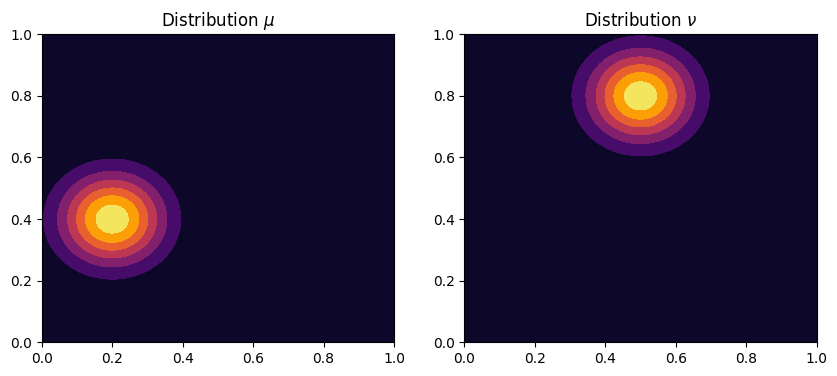

In [16]:
def generate_2d_gaussian(mean_x, mean_y, sigma_x, sigma_y, range_min, range_max, size=100):
    x = np.linspace(range_min, range_max, size)
    y = np.linspace(range_min, range_max, size)
    x, y = np.meshgrid(x, y)
    z = np.exp(-((x - mean_x)**2 / (2 * sigma_x**2) + (y - mean_y)**2 / (2 * sigma_y**2)))
    
    return x, y, z


range_min = 0
range_max = 1
x1, y1, mu = generate_2d_gaussian(
    mean_x = 0.2,
    mean_y = 0.4,
    sigma_x = 0.1,
    sigma_y = 0.1,
    range_min=range_min,
    range_max=range_max,
    size=100,
    )
x2, y2, nu = generate_2d_gaussian(
    mean_x = 0.5,
    mean_y = 0.8,
    sigma_x = 0.1,
    sigma_y = 0.1,
    range_min=range_min,
    range_max=range_max,
    size=100,
    )

# Plot these distributions
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].contourf(x1, y1, mu, cmap='inferno')
axs[1].contourf(x2, y2, nu, cmap='inferno')
axs[0].set_title('Distribution $\mu$')
axs[1].set_title('Distribution $\\nu$')